# DeFactify 📰 (Iteration 0)

This notebook is dedicated to developing a `Fake News Detection system` using machine learning techniques.

Since this is Iteration 0, I aimed for a `simpler approach` by focusing on the title and content of the articles to determine whether they are true or fake. As the project progresses, I will make it work with links as well.

Let's begin by importing the libraries and checking their versions.

In [ ]:
import sklearn
import pandas
import seaborn
import nltk
import re

import matplotlib.pyplot as plt
from wordcloud import WordCloud

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print("Library versions:")
print("- scikit-learn:", sklearn.__version__)  # 1.6.1
print("- pandas:", pandas.__version__)         # 2.2.3
print("- seaborn:", seaborn.__version__)       # 0.13.2
print("- nltk:", nltk.__version__)             # 3.9.1

Library versions:
- scikit-learn: 1.6.1
- pandas: 2.2.3
- seaborn: 0.13.2
- nltk: 3.9.1


## Data provisioning 📦

Now, let's load the BBC articles datasets that I scraped earlier.

In [9]:
bbc_dataset_v1 = pandas.read_csv('scraper/bbc_news_articles_v1.csv')
bbc_dataset_v1.shape

(39, 7)

In [10]:
bbc_dataset_v2 = pandas.read_csv('scraper/bbc_news_articles_v2.csv')
bbc_dataset_v2.shape

(38, 7)

I found an old dataset (https://huggingface.co/datasets/ErfanMoosaviMonazzah/fake-news-detection-dataset-English) containing real and fake news from 6-7 years ago, which has significantly more entries than I could have collected on my own. Therefore, for iteration 0, I decided to use this dataset. I plan to gather my own data later, as this dataset does not include links.

Additionally, I am only displaying certain columns because some of them were faulty when I import the data.

In [11]:
columns = ['id','title','text','subject','date','classification']
huggingface_dataset = pandas.read_csv('scraper/huggingface_dataset.csv', usecols=columns, low_memory=False)
huggingface_dataset.shape

(30016, 6)

The final step of the operation is to combine all 3 datasets into one.

In [12]:
combined_dataset = pandas.concat([bbc_dataset_v1, bbc_dataset_v2, huggingface_dataset], ignore_index=True)

combined_dataset.shape

(30093, 9)

## Sample the data 📃

In [13]:
combined_dataset.sample(10)

,title,link,source,author,date,text,classification,id,subject
26470,BREAKING FL VOTER FRAUD ALERT: “Tens Of Thousa...,NaN,NaN,NaN,2-Nov-16,https://twitter.com/TEN_GOP/status/79389017105...,0,19689,left-news
17964,Lebanese army gets two A-29 light-attack aircr...,NaN,NaN,NaN,31-Oct-17,The United States delivered two A-29 Super Tuc...,1,16020,worldnews
16294,WOW! Why George W. Bush Never Left DC Until Af...,NaN,NaN,NaN,24-Dec-15,"Meanwhile, the Obama s jet off to Hawaii every...",0,14752,politics
29715,HANNITY AND TUCKER CARLSON: THE 5 MAJOR FORCES...,NaN,NaN,NaN,17-May-17,Sean Hannity and Tucker Carlson went after the...,0,10859,politics
7511,"Labor Dept forecasts costs, retiree gains from...",NaN,NaN,NaN,6-Apr-16,A new rule aimed at protecting retirement fund...,1,10056,politicsNews
8143,POPULAR CONSERVATIVE SENATOR JEFF SESSIONS Say...,NaN,NaN,NaN,9-Jun-16,Senator Jess Sessions tough love talk may be ...,0,13729,politics
11959,Milwaukee County sheriff rescinds Homeland Sec...,NaN,NaN,NaN,18-Jun-17,"Milwaukee County Sheriff David Clarke, an Afri...",1,3138,politicsNews
12388,Desperate GOP LITERALLY Spreads Trump’s Wireta...,NaN,NaN,NaN,23-Mar-17,It was bound to happen as soon as House Inte...,0,2032,News
17408,BREAKING NEWS: SHOOTER Ambushes GOP Congressme...,NaN,NaN,NaN,14-Jun-17,Rep. Steve Scalise was shot Wednesday morning ...,0,18496,left-news
24061,Maddow Mocks GOP By Turning Their Freak Out Ab...,NaN,NaN,NaN,6-May-16,MSNBC host Rachel Maddow found the perfect way...,0,6518,News


The data from `Hugging Face` did not include links, sources or authors, so I will hide them at this stage of the project and focus on the title, text and classification in terms of important features.

In [14]:
cleaned_columns = ['title','text','classification']
focused_data = combined_dataset.loc[:,cleaned_columns]

focused_data.sample(10)

,title,text,classification
9974,Storm-battered Antigua asks U.S. to settle 12-...,Antigua and Barbuda asked the United States on...,1
11172,WATCH: DEMOCRAT STATE SENATOR Who Said She Wou...,"Last week, MO State Senator Chappelle-Nadal sa...",0
13997,CNN’s Jake Tapper Calls Allahu Akbar ‘Beautifu...,This is how the left thinks. Just a few minute...,0
15168,"On final trip, Carter looks to reassure Asia a...",U.S. Defense Secretary Ash Carter makes his la...,1
13480,"French PM shrugs off labor protests, truckers ...",French Prime Minister Edouard Philippe has shr...,1
27200,Factbox: Trump's presidency prompts some notes...,Donald Trump’s inauguration as U.S. president ...,1
24587,‘No Real Logic’: French Translators Having A V...,Reality show star turned president Donald Trum...,0
7317,WHOA! DEMOCRATIC Strategist Gives Crooked Hill...,"The most unpopular, deplorable woman in Americ...",0
16398,Algeria's ruling caste set on orderly successi...,Algerians are facing the eventual departure of...,1
7153,Obama has 'better things to do' than comment o...,U.S. President Barack Obama on Friday said he ...,1


## Preprocessing 🛠️

Before training the algorithm, it is essential to ensure that the dataset is clean and free of any issues. 

We can achieve this by checking for any rows that contain missing data and if we find any, we should remove them.

In [15]:
focused_data.isnull().sum()

title              0
text               3
classification    16
dtype: int64

In [16]:
cleaned_dataset = focused_data.dropna()

cleaned_dataset.shape

(30074, 3)

While working with the dataset, I discovered that some entries in the classification column contain text instead of 0 or 1.

In [17]:
cleaned_dataset['classification'].unique()

array([1, '1', '0',
       '  No matter who you vote for the government always gets in. We ll see which government gets in tomorrow.READ MORE ELECTION NEWS AT: 21st Century Wire 2016 FilesSUPPORT 21WIRE   SUBSCRIBE & BECOME A MEMBER @21WIRE.TV"',
       ' lowered educational standards to accommodate Hispanics',
       ' and the unrestricted right to taxpayer-funded abortion-on-demand.National Council of La Raza: This group lobbies for racial preferences',
       ' according to KoloTV in Las Vegas: Nevada s Homeland Security Commission on Thursday approved a grant allocation plan that will increase funding for the region s fusion center to nearly $1.1 million',
       ' that the status quo reflects the nation s unique good fortune in being favored by God and that those calling for change are merely subversive troublemakers. As the French ancien r gime',
       ' Stone enlisted some 200 hardened criminals for the realistic riot scene.Cult Crimes & The Daily ShooterWhen concerning America

To prevent this issue, we will exclude rows where the classification is only 0 or 1.

In [18]:
cleaned_dataset = cleaned_dataset[cleaned_dataset['classification'].isin(['0', '1'])]

cleaned_dataset.shape

(29984, 3)

I am making a final check to ensure that the data contains only 0s and 1s. Overall, we can see that the data is evenly distributed between fake and real news.

In [19]:
group_info = cleaned_dataset.groupby(["classification"])["classification"].count()
group_info

classification
0    15462
1    14522
Name: classification, dtype: int64

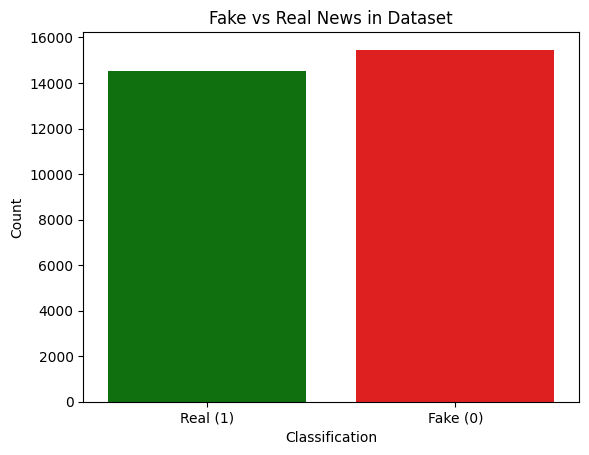

In [20]:
plt.figure()
seaborn.countplot(data=cleaned_dataset, x='classification', hue='classification', palette={'0': 'red', '1': 'green'})
plt.title('Fake vs Real News in Dataset')
plt.xlabel('Classification')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Real (1)', 'Fake (0)'])
plt.show()

### Target variable 🎯 

Our main target this iteration is the `title` and `content` of the article, so we will combine them into one.

In [21]:
cleaned_dataset['content'] = cleaned_dataset['title'] + ' : ' + cleaned_dataset['text']
print(cleaned_dataset['content'])

77       Ex-CIA head says Trump remarks on Russia inter...
78       YOU WON’T BELIEVE HIS PUNISHMENT! HISPANIC STO...
79       Federal Reserve governor Powell's policy views...
80       SCOUNDREL HILLARY SUPPORTER STARTS “TrumpLeaks...
81       NANCY PELOSI ARROGANTLY DISMISSES Questions on...
                               ...                        
30088    U.S. aerospace industry urges Trump to help Ex...
30089    Highlights: Hong Kong leader Carrie Lam delive...
30090    Obama Literally LAUGHS At Claims That Brexit M...
30091    Syrian army takes full control of Deir al-Zor ...
30092    U.S., Israel sign $38 billion military aid pac...
Name: content, Length: 29984, dtype: object


### Stopwords 🛑

Stopwords are the `most commonly used words` in a language, such as "in," "on," "a," "an," and "the" in English. 

When evaluating whether an article is fake or not, we do not need these words, so we can choose to remove them.

In [22]:
stemmer = PorterStemmer()

stop_words = set(stopwords.words('English'))

print(stopwords.words('English'))

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

### Stemming 🌱

Stemming is a technique that helps algorithms function more effectively. It reduces words to their `root form`. For instance, the words "programming" "programmer" and "programs" can all be reduced to the common word stem "program."

In [23]:
def stemming(content):
    tokens = word_tokenize(re.sub(r'[^a-zA-Z]', ' ', content.lower()))
    stemmed_tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return ' '.join(stemmed_tokens)

In [24]:
cleaned_dataset['content'] = cleaned_dataset['content'].apply(stemming)

In [25]:
print(cleaned_dataset[['content']])

                                                 content
77     ex cia head say trump remark russia interfer d...
78     believ punish hispan store owner swindl tax pa...
79     feder reserv governor powel polici view word p...
80     scoundrel hillari support start trumpleak camp...
81     nanci pelosi arrogantli dismiss question crook...
...                                                  ...
30088  u aerospac industri urg trump help ex im bank ...
30089  highlight hong kong leader carri lam deliv mai...
30090  obama liter laugh claim brexit mean trump win ...
30091  syrian armi take full control deir al zor isla...
30092  u israel sign billion militari aid packag unit...

[29984 rows x 1 columns]


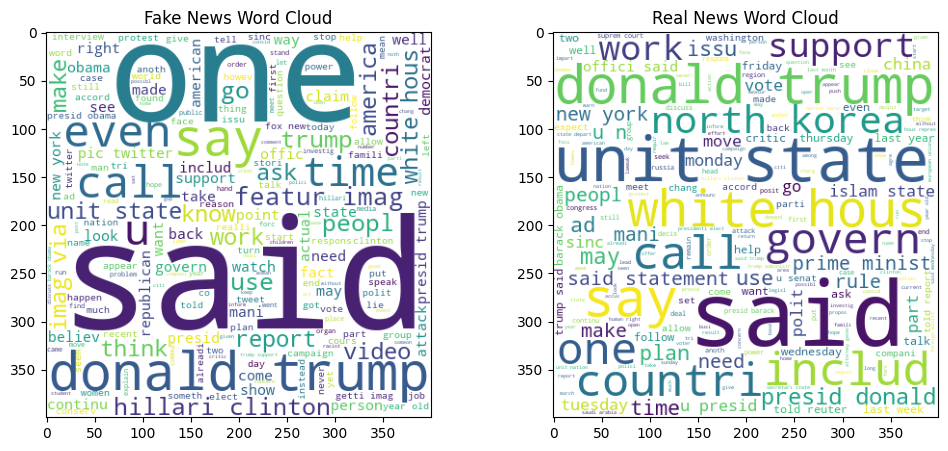

In [26]:
fake_news = ' '.join(cleaned_dataset[cleaned_dataset['classification'] == '0']['content'])
real_news = ' '.join(cleaned_dataset[cleaned_dataset['classification'] == '1']['content'])

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].imshow(WordCloud(width=400, height=400, background_color='white').generate(fake_news))
ax[0].set_title("Fake News Word Cloud")

ax[1].imshow(WordCloud(width=400, height=400, background_color='white').generate(real_news))
ax[1].set_title("Real News Word Cloud")

plt.show()

### Converting the textual data to numerical data 🔁

TF-IDF (Term Frequency-Inverse Document Frequency) is used to convert textual data into numerical features, allowing machine learning models like K-NN to process it. It assigns weights to words based on their frequency in a document and their rarity across the dataset, highlighting important terms. The `TfidfVectorizer` transforms the cleaned text data into a numerical array, which is used as the input features (X). The target labels (y), already numerical, represent the classification of each text as real (1) or fake (0).

In [27]:
X = cleaned_dataset['text'].values
Y = cleaned_dataset['classification'].values

In [45]:
vectorizer = TfidfVectorizer()

X = vectorizer.fit_transform(cleaned_dataset['content']).toarray()
y = cleaned_dataset['classification']

print(X)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### Splitting into train/test 🪓

We will use 80% of the data for training and the rest - 20% for testing.

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print("There are in total", len(X), "observations, of which", len(X_train), "are now in the train set, and", len(X_test), "in the test set.")

There are in total 29984 observations, of which 23987 are now in the train set, and 5997 in the test set.


### Modelling 🧬

As mentioned earlier, we will use K-NN for iteration 0. After this, the test set will be used to calculate the model's accuracy, which indicates how well it performs.

In [ ]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

In [34]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of KNN model: {accuracy * 100:.2f}%")

Accuracy of KNN model: 86.31%


## Evaluation 🔬

This report evaluates the accuracy of recognising news as fake or real and assesses the model's performance.

In [35]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.80      0.86      3048
           1       0.82      0.93      0.87      2949

    accuracy                           0.86      5997
   macro avg       0.87      0.86      0.86      5997
weighted avg       0.87      0.86      0.86      5997



It is important to consider the confusion matrix when evaluating a model's performance. The overall accuracy of the model is 86%. However, the recall for "Real" is quite high, at nearly 93%, indicating that the model correctly identifies most real cases. While the rate of false positives is somewhat high, this is a concern for iteration 1 of the model.

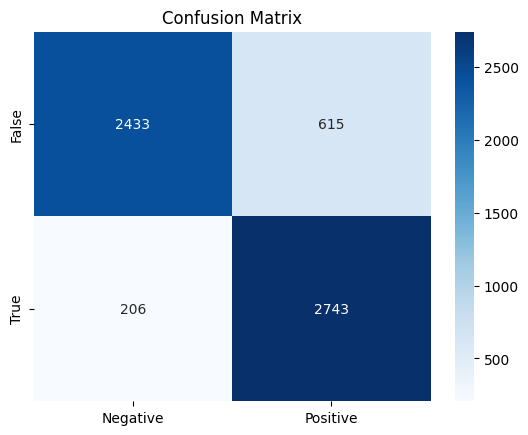

In [38]:
cm = confusion_matrix(y_test, y_pred)

seaborn.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['False', 'True'])
plt.title('Confusion Matrix')
plt.show()


## Test 🔎

In addition to the actual tests, I wanted to see how it performed on its own. Therefore, I took an absurd news story and one recent article from BBC to conduct the test. This is the result:

In [33]:
def predict_news(title, text):
    content = title + " : " + text
    content = stemming(content)
    content_vector = vectorizer.transform([content]).toarray()
    prediction = knn.predict(content_vector)
    return "REAL" if prediction[0] == '1' else "FAKE"

# Example: Fake News
fake_title = "Ancient Pyramid Found on Mars—NASA Hiding the Truth?"
fake_text = "Independent researchers claim a massive pyramid is found on Mars. NASA refuses to comment."
print("Prediction:", predict_news(fake_title, fake_text))

# Example: Real News
real_title = "War ‘tour’, football and graffiti: How Russia is trying to influence Africa"
real_text = "Russian influence in Africa grows through media and cultural initiatives."
print("Prediction:", predict_news(real_title, real_text))

Prediction: FAKE
Prediction: REAL
